In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import itertools
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
import requests
from sklearn.model_selection import train_test_split
%matplotlib inline

In [16]:
real_path = 'data/real'
fake_path = 'data/fake'


In [17]:
base_dir = '/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(directory, 'real'), exist_ok=True)
    os.makedirs(os.path.join(directory, 'fake'), exist_ok=True)

In [ ]:
split_data(real_path, os.path.join(train_dir, 'real'), os.path.join(val_dir, 'real'), os.path.join(test_dir, 'real'))
split_data(fake_path, os.path.join(train_dir, 'fake'), os.path.join(val_dir, 'fake'), os.path.join(test_dir, 'fake'))

In [18]:
batch_size = 16
img_size = (224, 224)

data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.4,1.5],
    zoom_range=0.3,
    rotation_range=40,
    fill_mode='nearest'
)

train_batches = data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

valid_batches = data_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_batches = data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 26139 images belonging to 2 classes.
Found 5943 images belonging to 2 classes.
Found 5934 images belonging to 2 classes.


In [7]:
class_labels = np.unique(train_batches.classes)  
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=class_labels,
    y=train_batches.classes  
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.7144926743931773, 1: 1.6655409710717473}


In [8]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(),
    layers.GlobalAveragePooling2D(),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(units=2, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(x=train_batches,
    validation_data=valid_batches,
    epochs=5,
    class_weight=class_weights_dict,
    verbose=1,
)

Epoch 1/5
  59/1634 [>.............................] - ETA: 7:55 - loss: 1.0328 - accuracy: 0.5138

C:\Users\Phattaradanai\anaconda3\envs\tenserflowgpu\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1634/1634 [==============================] - 805s 471ms/step - loss: 0.6942 - accuracy: 0.5529 - val_loss: 0.6563 - val_accuracy: 0.6450
Epoch 2/5
1634/1634 [==============================] - 747s 457ms/step - loss: 0.5923 - accuracy: 0.7033 - val_loss: 0.5303 - val_accuracy: 0.7892
Epoch 3/5
1634/1634 [==============================] - 685s 419ms/step - loss: 0.5153 - accuracy: 0.7767 - val_loss: 0.4890 - val_accuracy: 0.7945
Epoch 4/5
1634/1634 [==============================] - 728s 446ms/step - loss: 0.4905 - accuracy: 0.7944 - val_loss: 0.5421 - val_accuracy: 0.7459
Epoch 5/5
1634/1634 [==============================] - 755s 462ms/step - loss: 0.4733 - accuracy: 0.8024 - val_loss: 0.5022 - val_accuracy: 0.7829


In [12]:
history_dict = history.history
model_loss = pd.DataFrame(history_dict)

In [13]:
model_loss

,loss,accuracy,val_loss,val_accuracy
0,0.694229,0.552852,0.656276,0.644960
1,0.592310,0.703279,0.530266,0.789164
2,0.515308,0.776656,0.488951,0.794548
3,0.490537,0.794369,0.542080,0.745920
4,0.473285,0.802441,0.502169,0.782938


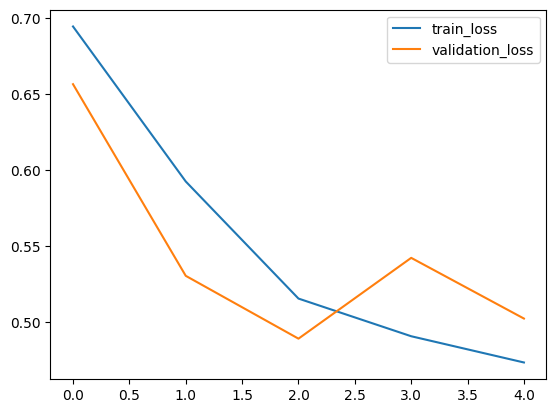

In [15]:
plt.plot(model_loss['loss'],label = 'train_loss')
plt.plot(model_loss['val_loss'],label = 'validation_loss')
plt.legend()
plt.show() 

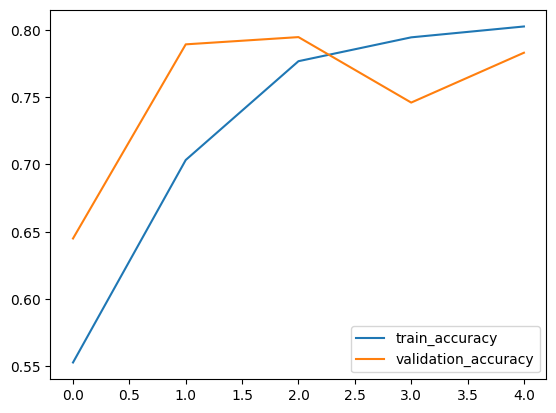

In [16]:
plt.plot(model_loss['accuracy'],label = 'train_accuracy')
plt.plot(model_loss['val_accuracy'],label = 'validation_accuracy')
plt.legend()
plt.show()

In [17]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=1)

116/371 [========>.....................] - ETA: 1:55

C:\Users\Phattaradanai\anaconda3\envs\tenserflowgpu\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


371/371 [==============================] - 156s 419ms/step


In [18]:
print(classification_report(test_batches.classes,np.argmax(predictions, axis = -1)))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      4153
           1       0.59      0.86      0.70      1781

    accuracy                           0.78      5934
   macro avg       0.76      0.80      0.76      5934
weighted avg       0.83      0.78      0.79      5934



In [12]:
test2_dir = 'data/test2/'

test_batches2 = data_gen.flow_from_directory(
    test2_dir,
    target_size=img_size
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 40 images belonging to 2 classes.


In [22]:
predictions = model.predict(x=test_batches2, steps=len(test_batches2), verbose=1)

C:\Users\Phattaradanai\anaconda3\envs\tenserflowgpu\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 2s 459ms/step


In [23]:
print(classification_report(test_batches2.classes,np.argmax(predictions, axis = -1)))

              precision    recall  f1-score   support

           0       0.53      0.85      0.65        20
           1       0.62      0.25      0.36        20

    accuracy                           0.55        40
   macro avg       0.58      0.55      0.51        40
weighted avg       0.58      0.55      0.51        40



In [19]:
model.save('modelcnn5epoch.h5')